In [41]:
import torch
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import numpy as np
import seaborn as sns
import torch.nn.functional as F
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == 'cuda':
    print(f"Device name: {torch.cuda.get_device_name(0)}")
    print(f"Memory Allocated: {torch.cuda.memory_allocated(0) / 1024. / 1024.} megabytes")
    print(f"Memory Cached: {torch.cuda.memory_reserved(0) / 1024. / 1024.} megabytes")
    print(f"Total Memory: {torch.cuda.get_device_properties(0).total_memory / 1024. / 1024.} megabytes")
else:
    print("CUDA is not available. Using CPU instead.")

True
Using device: cuda
Device name: NVIDIA GeForce RTX 2060
Memory Allocated: 27.3984375 megabytes
Memory Cached: 3812.0 megabytes
Total Memory: 6143.6875 megabytes


In [42]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn

class ImageDataset(Dataset):
    def __init__(self, txt_loc, transform=None):
        print("Initializing image dataset.")
        self.image_labels = []
        self.image_paths = self.find_full_paths(txt_loc)
        self.transform = transform
        print(f"Total images found: {len(self.image_paths)}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        img_path, label = self.image_paths[index]
        try:
            image = Image.open(img_path)
            if self.transform:
                image = self.transform(image)
            return image, torch.tensor(label, dtype=torch.long)
        except IOError as e:
            print(f"Error loading image {img_path}: {e}")
            return None, None

    def find_file_by_suffix(self, directory, filename_suffix):
        for root, dirs, files in os.walk(directory):
            for filename in files:
                if filename.endswith(filename_suffix):
                    return os.path.join(root, filename)
        return None

    def find_full_paths(self, txt_loc):
        data_dirs = os.listdir("color/")
        final_paths = []
        with open(txt_loc, 'r') as infile:
            lines = [line.strip() for line in infile.readlines()]
        for line in lines:
            parts = line.rsplit(' ', 1)
            filename = parts[0]
            label = int(parts[1]) - 1
            directory_index = label
            file_location = f'color/{data_dirs[directory_index]}/'
            full_path = self.find_file_by_suffix(file_location, filename)
            if full_path:
                final_paths.append((full_path, label))
            else:
                print(f"File not found: {filename} in {file_location}")
        return final_paths

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

class InceptionModule(nn.Module):
    def __init__(self, in_channels, f1, f3_reduce, f3, f5_reduce, f5, pool_proj):
        super(InceptionModule, self).__init__()
        self.branch1 = nn.Conv2d(in_channels, f1, kernel_size=1)

        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, f3_reduce, kernel_size=1),
            nn.Conv2d(f3_reduce, f3, kernel_size=3, padding=1)
        )

        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, f5_reduce, kernel_size=1),
            nn.Conv2d(f5_reduce, f5, kernel_size=5, padding=2)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, 1)

In [44]:
class GoogLeNet(nn.Module):
    def __init__(self, num_classes=31):
        super(GoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2),
            nn.Conv2d(64, 64, kernel_size=1),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

        # Add inception blocks with the corresponding parameters
        self.a3 = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.b3 = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # More inception modules would be added here following the original architecture

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(480, num_classes)  # Adjust the input size to 480

    def forward(self, x):
        x = self.pre_layers(x)
        x = self.a3(x)
        x = self.b3(x)
        x = self.maxpool(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)    
        x = self.dropout(x)
        x = self.fc(x)
        return x


In [45]:
transform = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

classes = [i for i in range(1, 32)]
train_dataset = ImageDataset(txt_loc='./train.txt', transform=transform)
test_dataset = ImageDataset(txt_loc='./test.txt', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=0)

Initializing image dataset.
Total images found: 34011
Initializing image dataset.
Total images found: 8498


In [46]:
classes = [f'{i}' for i in range(1, 32)]

def plot_confusion_matrix(true_labels, predicted_labels, classes):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, cmap=plt.cm.Purples, fmt='g', 
                 xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    
def plot_roc_curve_multiclass(num_classes, true_labels, probabilities):
    true_labels = label_binarize(true_labels, classes=[i for i in range(num_classes)])
    n_classes = true_labels.shape[1]
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], probabilities[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    colors = iter(plt.cm.rainbow(np.linspace(0, 1, n_classes)))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=next(colors), label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall(labels, probabilities, num_classes):
    labels = label_binarize(labels, classes=[i for i in range(num_classes)])
    
    precision = dict()
    recall = dict()
    pr_auc = dict()

    for i in range(num_classes):
        precision[i], recall[i], _ = precision_recall_curve(labels[:, i], probabilities[:, i])
        pr_auc[i] = auc(recall[i], precision[i])

    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (PR AUC = {pr_auc[i]:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Class-wise Precision-Recall Curves')
    plt.legend(loc="best")
    plt.show()
    
def evaluate_model(model, device, data_loader, classes):
    model.eval()
    correct = 0
    total = 0
    true_labels = []
    predicted_labels = []
    probabilities_list = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            probabilities = F.softmax(outputs, dim=1)
            probabilities_list.append(probabilities.cpu())
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    print(f'Accuracy: {accuracy:.2f}%')
    print(f'F1 Score: {f1:.2f}')

    probabilities = torch.cat(probabilities_list, dim=0)
    true_labels = torch.tensor(true_labels)
        
    return true_labels, predicted_labels, probabilities

In [47]:
batch_sizes = [32, 1] # OTHER BATCH SIZES DO NOT WORK???
learning_rates = [0.001, 0.0005, 0.0001]
epochs = [20]

Starting training with batch size=32, learning rate=0.001, epoch=20


Epoch [5/20]: 100%|██████████| 1063/1063 [02:42<00:00,  6.55it/s, loss=0.416]


Accuracy: 92.33%
F1 Score: 0.92


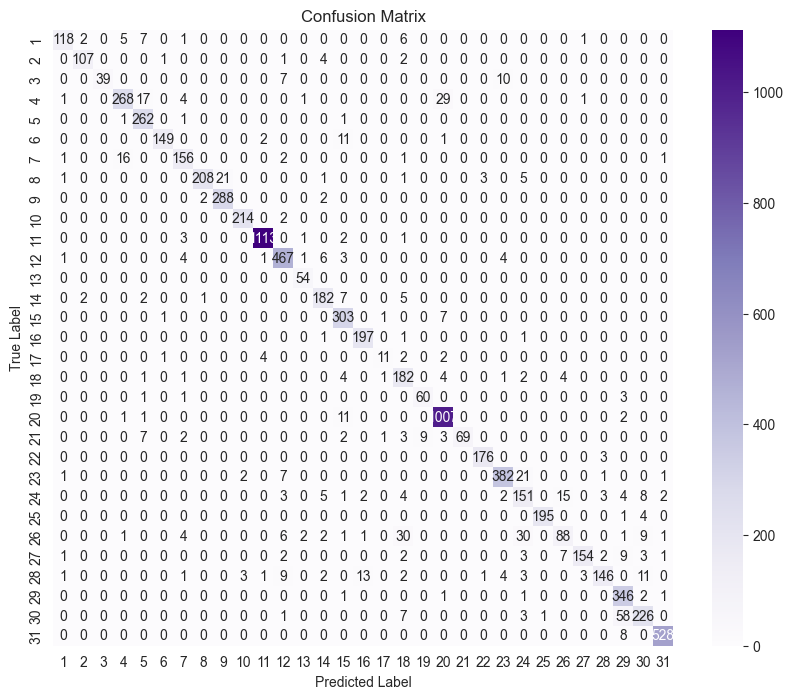

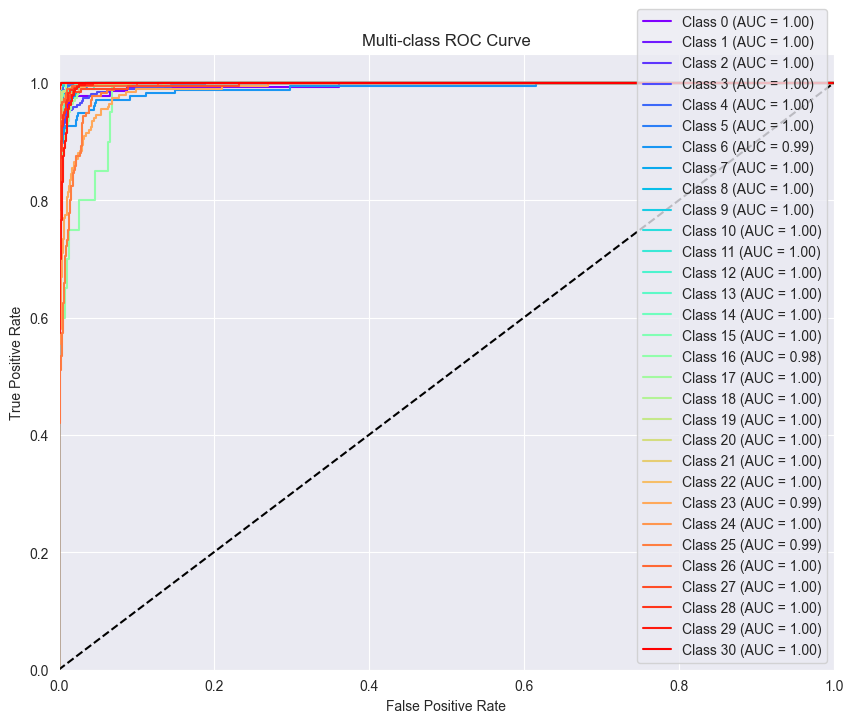

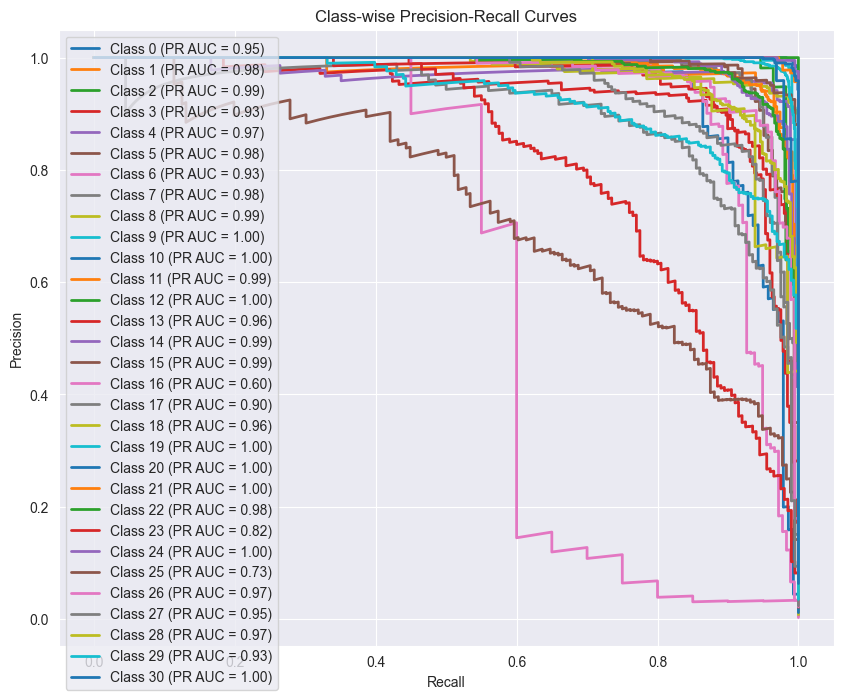

Epoch [10/20]: 100%|██████████| 1063/1063 [02:46<00:00,  6.40it/s, loss=0.195]


Accuracy: 95.72%
F1 Score: 0.96


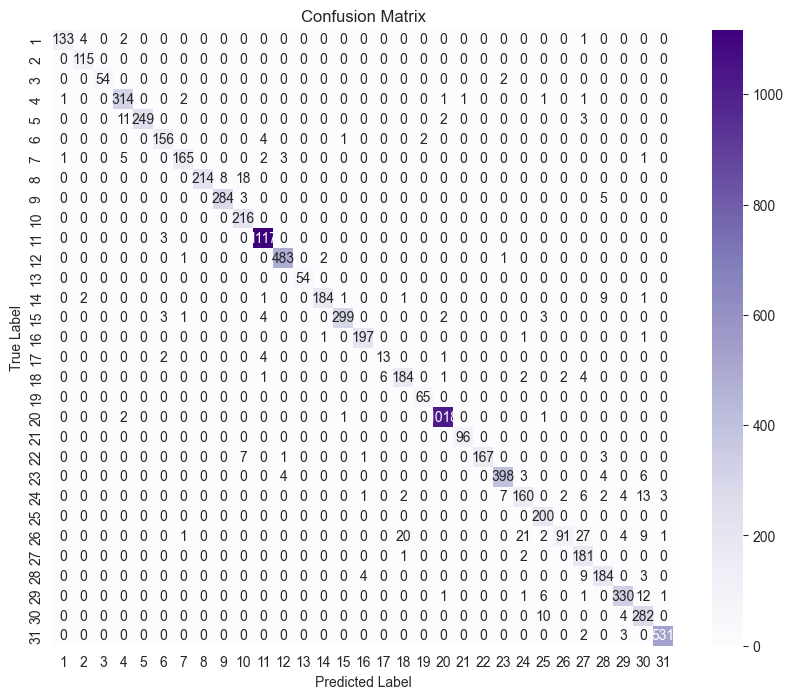

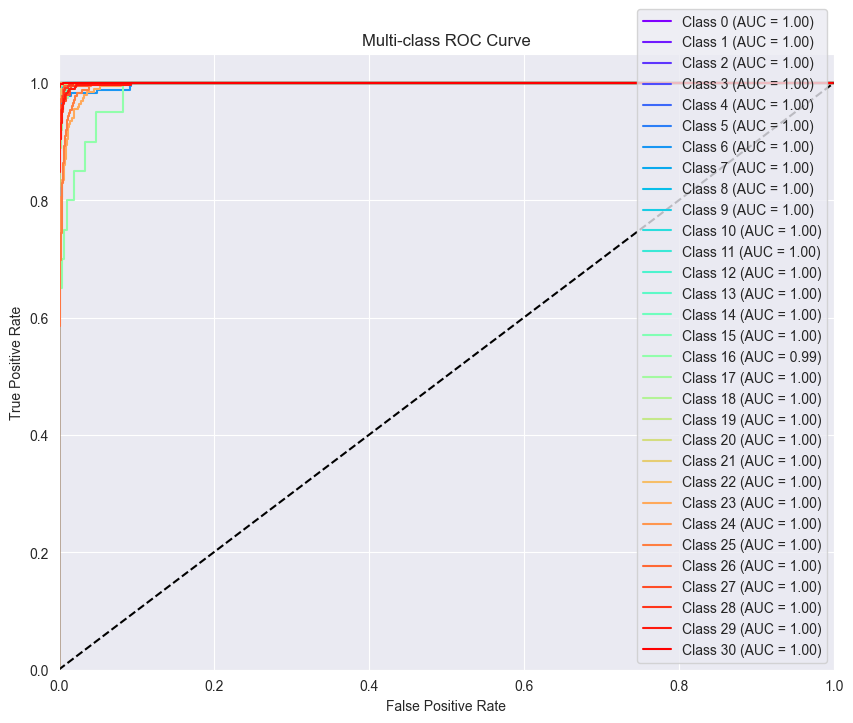

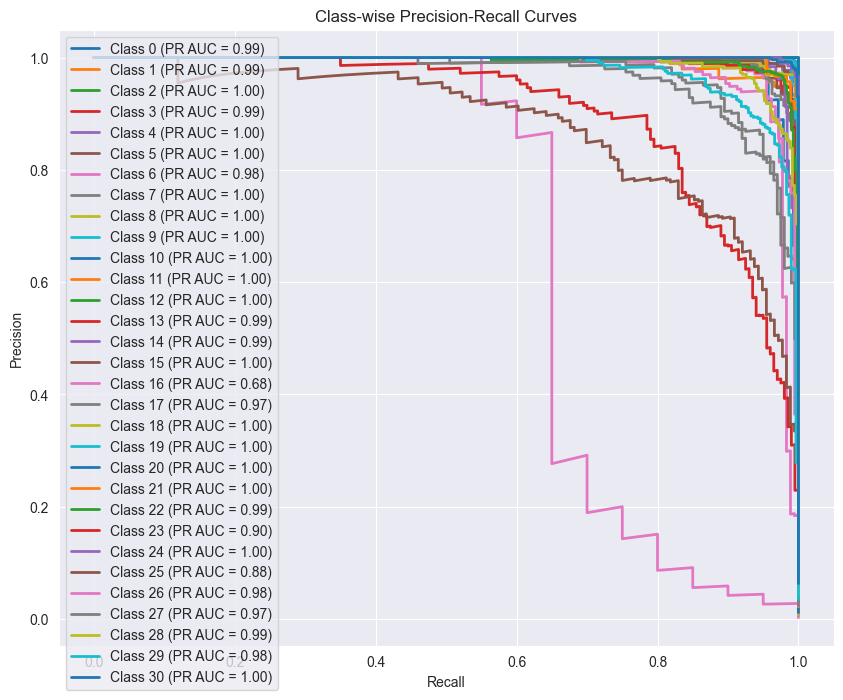

Epoch [15/20]: 100%|██████████| 1063/1063 [02:39<00:00,  6.67it/s, loss=0.132]


Accuracy: 93.40%
F1 Score: 0.93


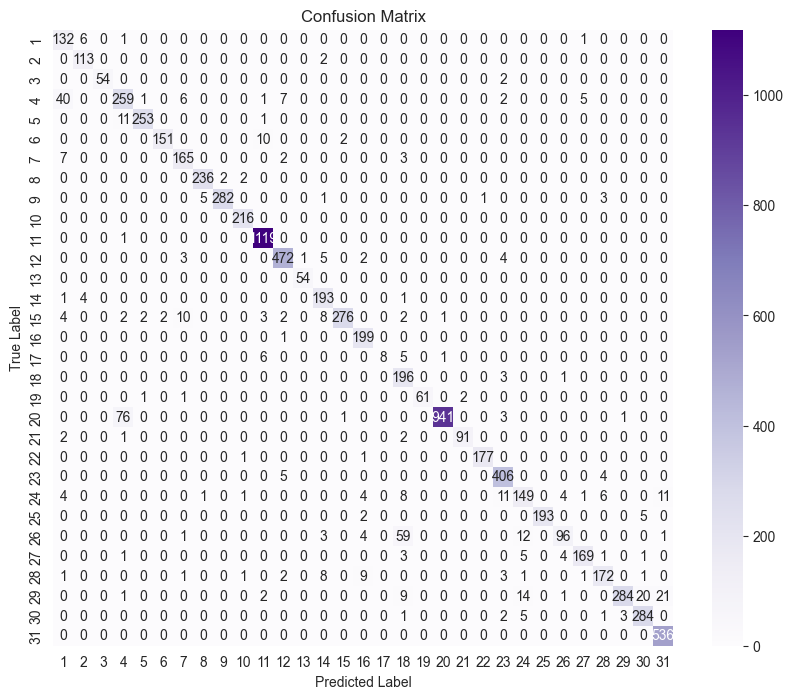

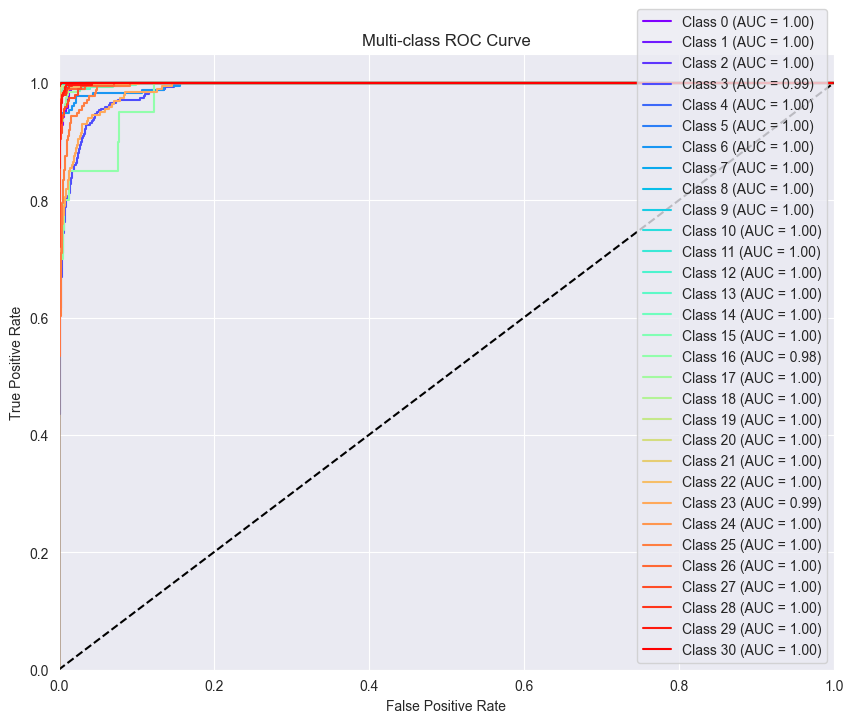

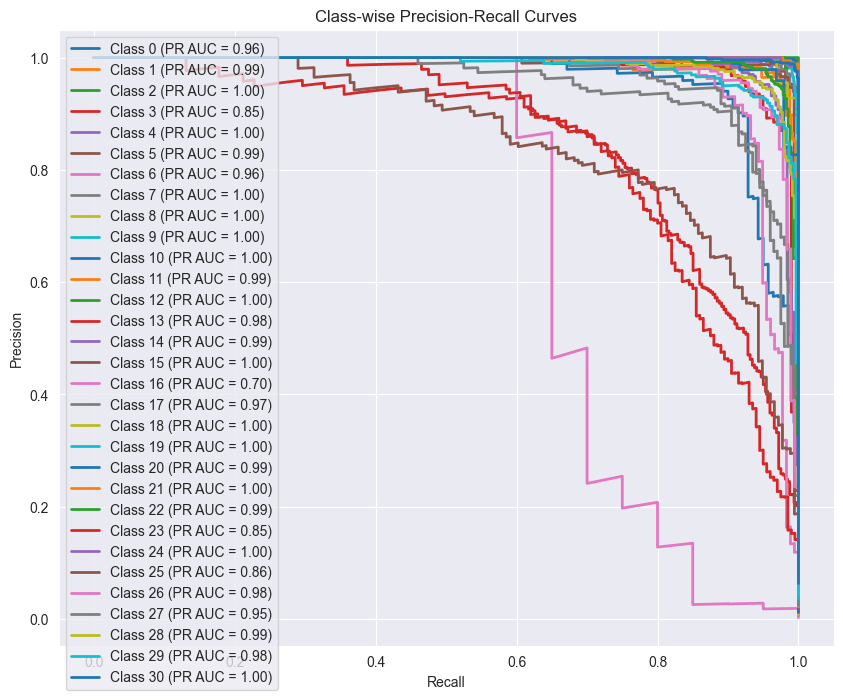

Epoch [20/20]: 100%|██████████| 1063/1063 [02:36<00:00,  6.78it/s, loss=0.128]


Accuracy: 93.42%
F1 Score: 0.93


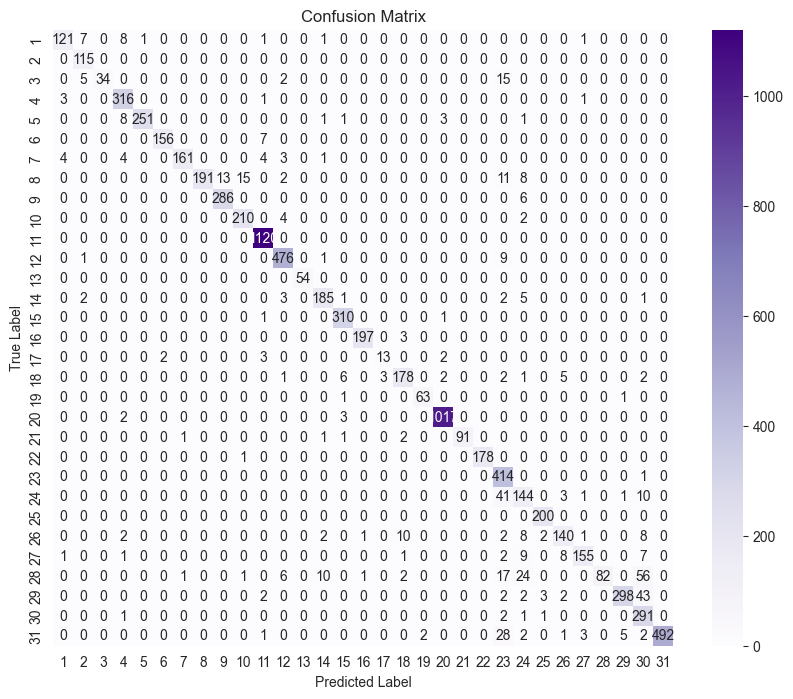

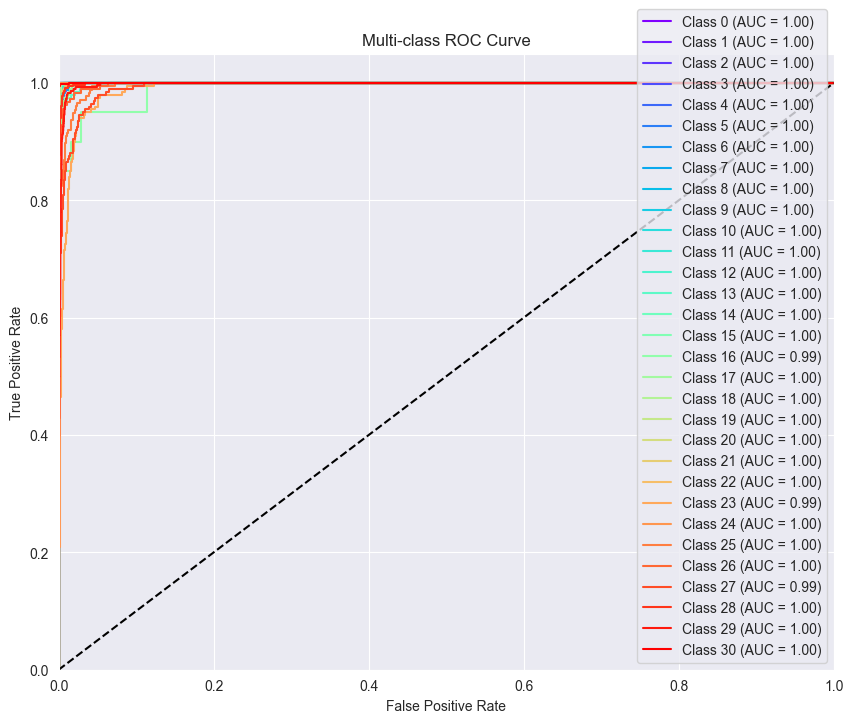

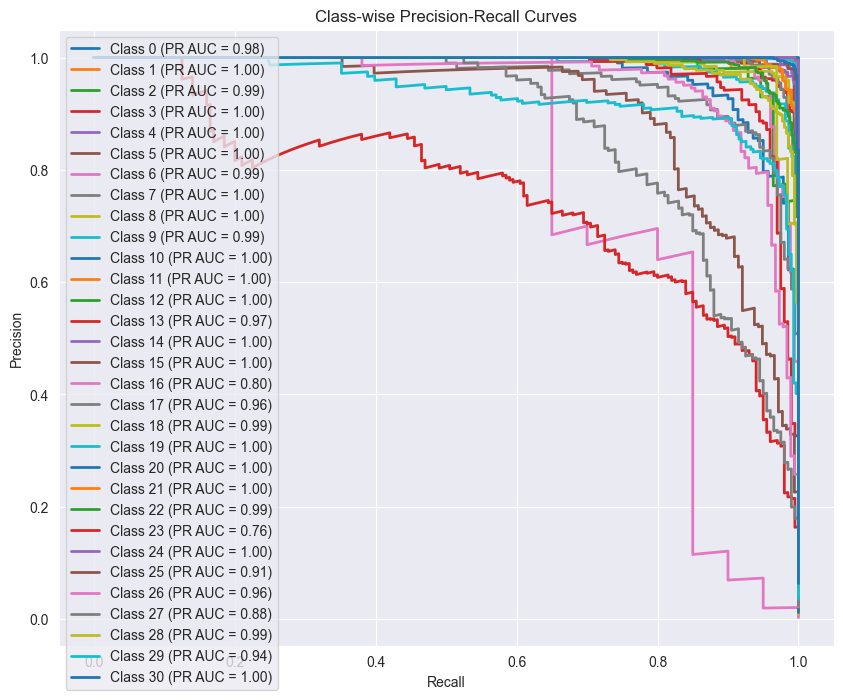

Starting training with batch size=32, learning rate=0.0005, epoch=20


Epoch [5/20]: 100%|██████████| 1063/1063 [02:35<00:00,  6.82it/s, loss=0.0702]


Accuracy: 97.76%
F1 Score: 0.98


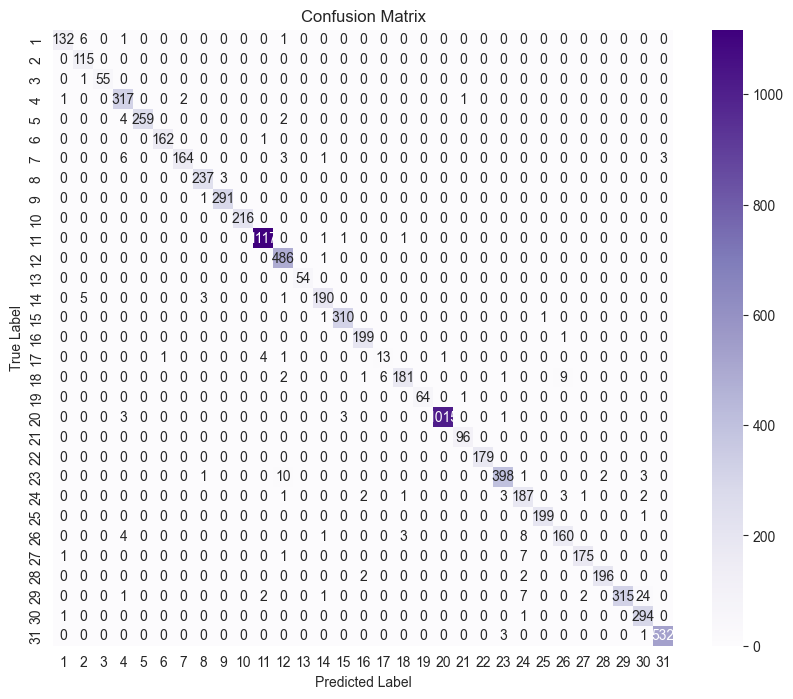

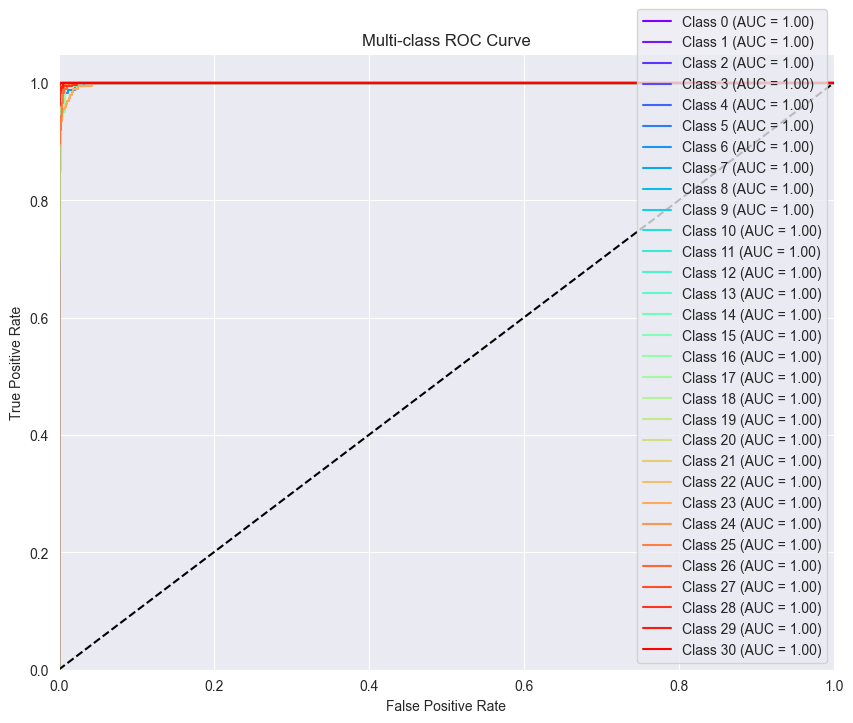

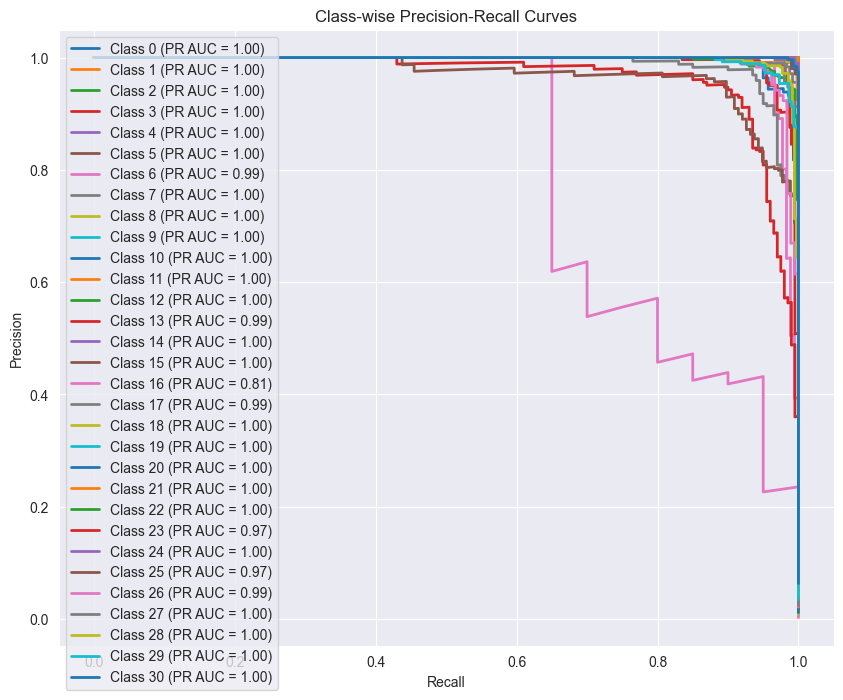

Epoch [10/20]: 100%|██████████| 1063/1063 [02:35<00:00,  6.84it/s, loss=0.0305]


Accuracy: 97.25%
F1 Score: 0.97


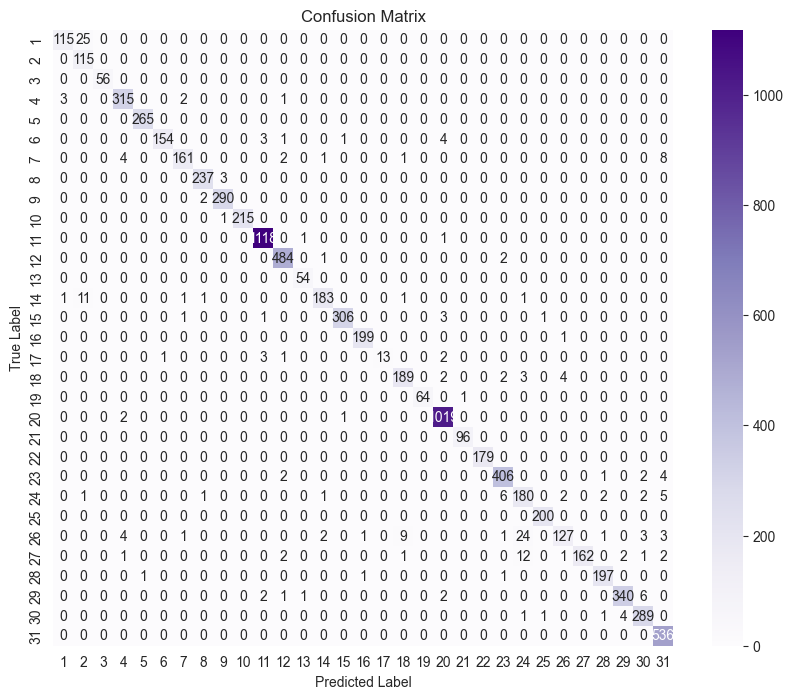

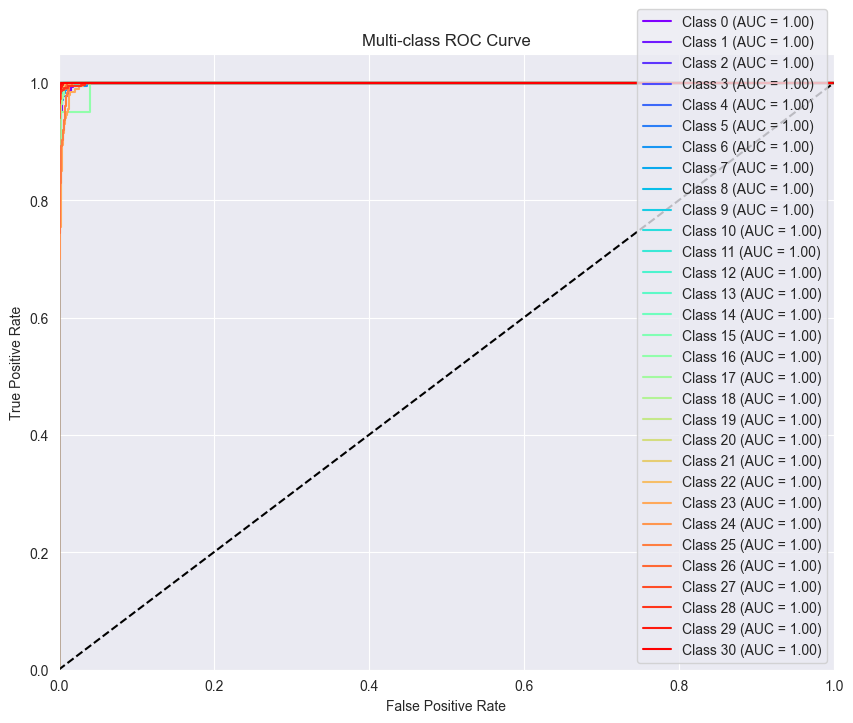

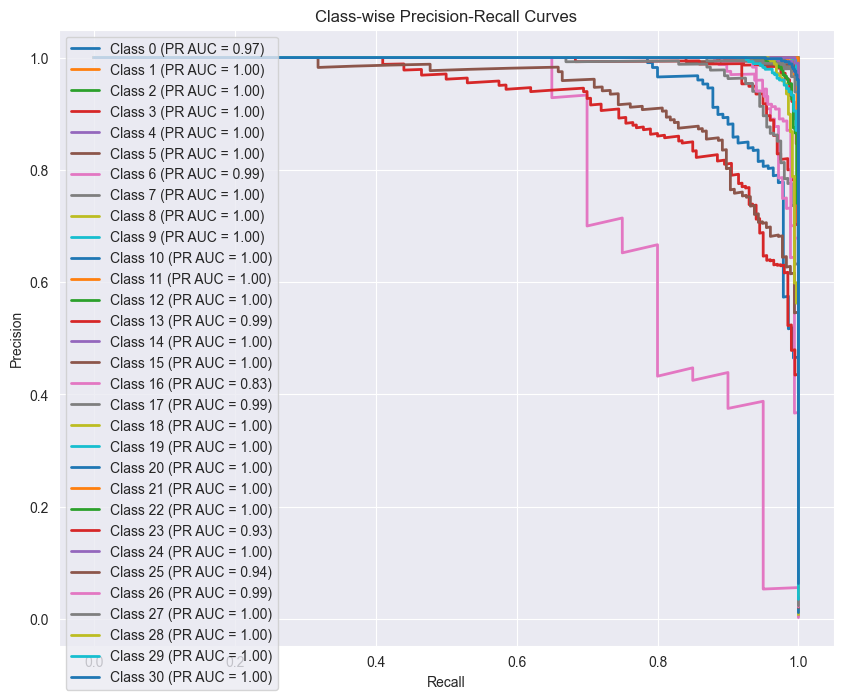

Epoch [15/20]: 100%|██████████| 1063/1063 [02:35<00:00,  6.85it/s, loss=0.0306]


Accuracy: 97.63%
F1 Score: 0.98


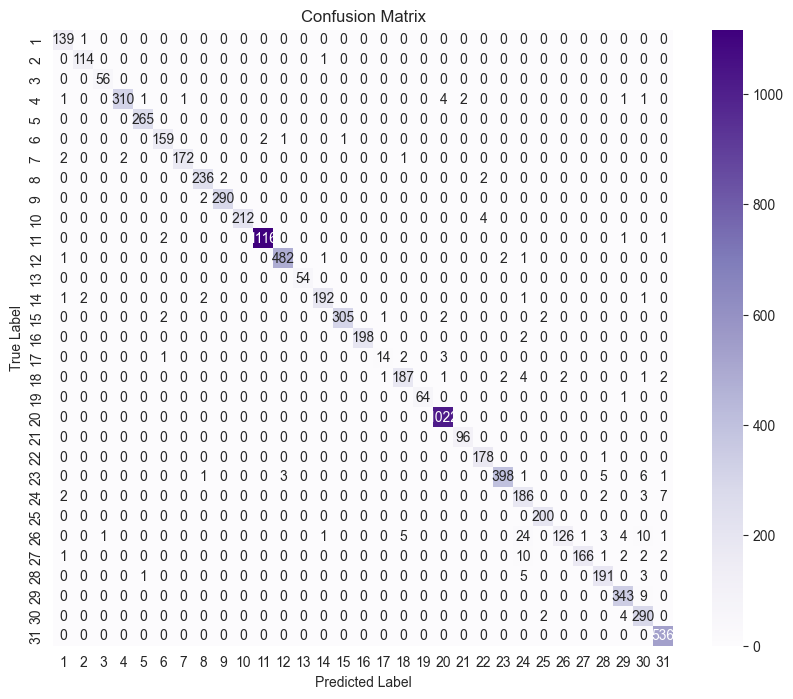

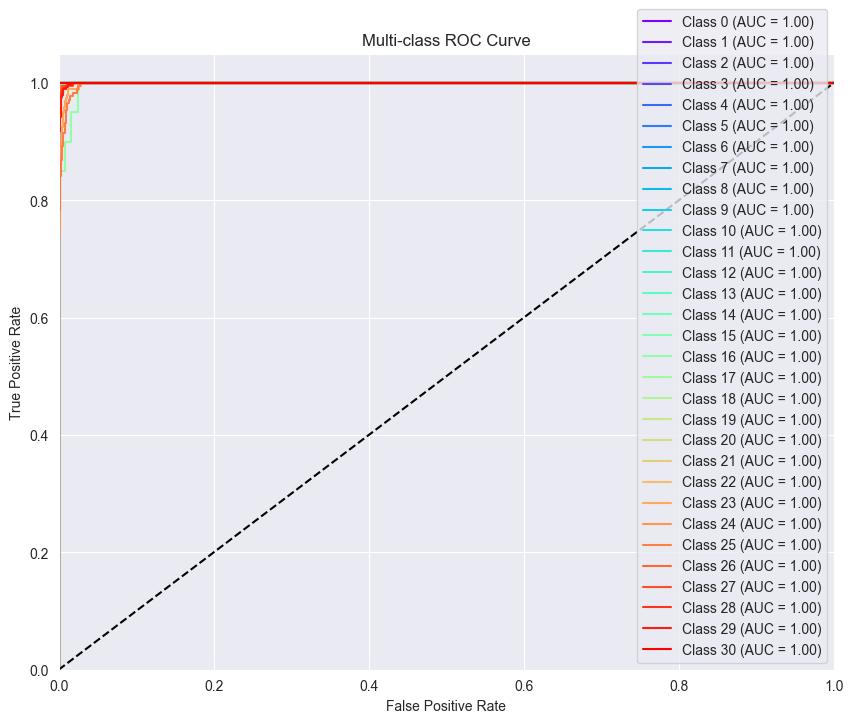

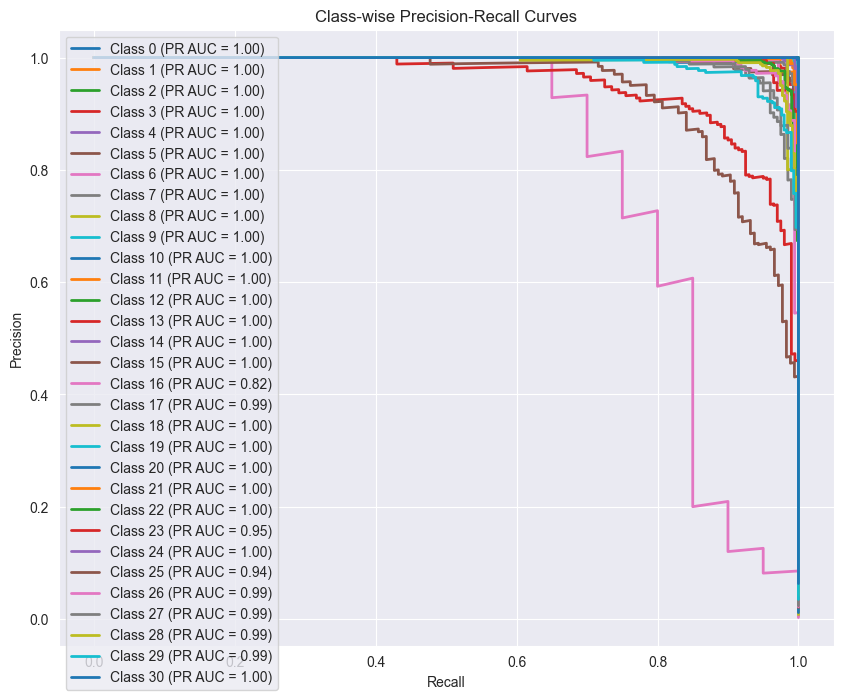

Epoch [20/20]: 100%|██████████| 1063/1063 [02:36<00:00,  6.81it/s, loss=0.0374]


Accuracy: 96.23%
F1 Score: 0.96


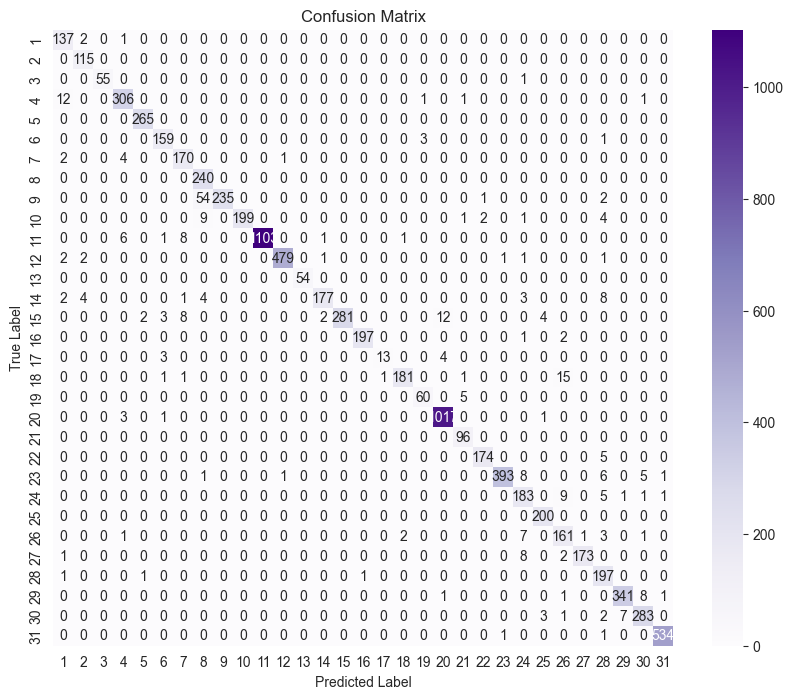

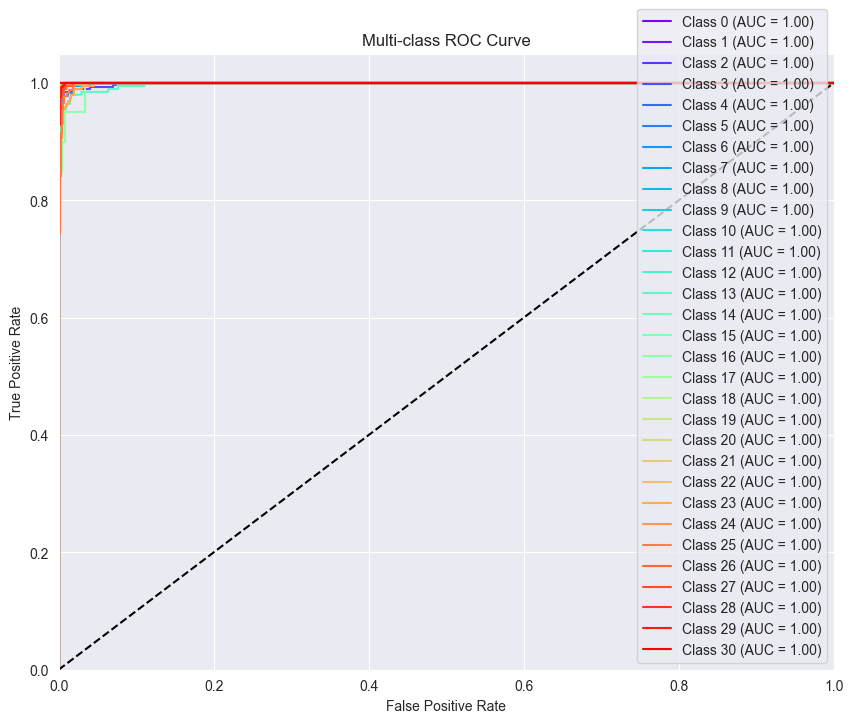

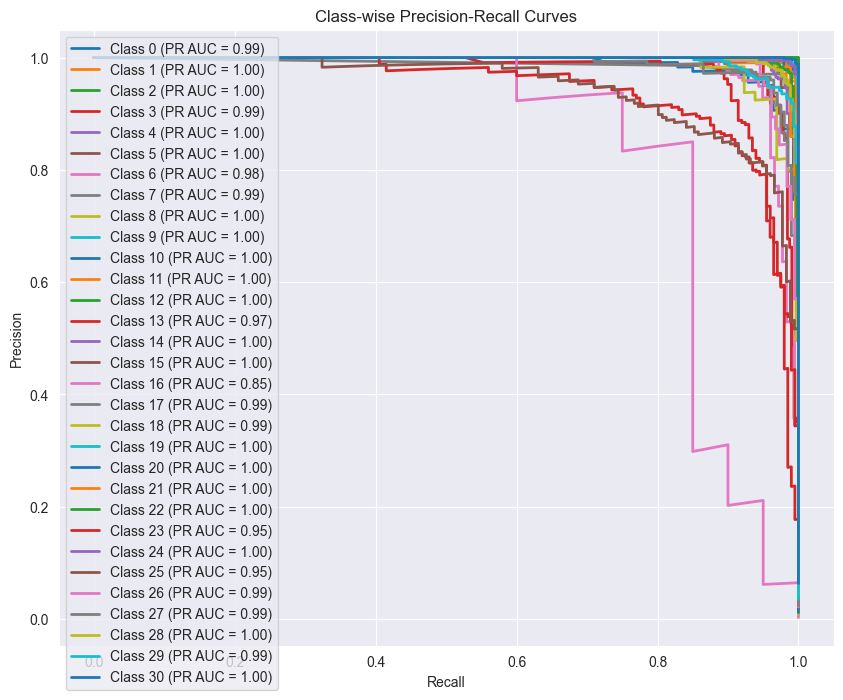

Starting training with batch size=32, learning rate=0.0001, epoch=20


Epoch [5/20]: 100%|██████████| 1063/1063 [02:36<00:00,  6.78it/s, loss=0.0103] 


Accuracy: 98.45%
F1 Score: 0.98


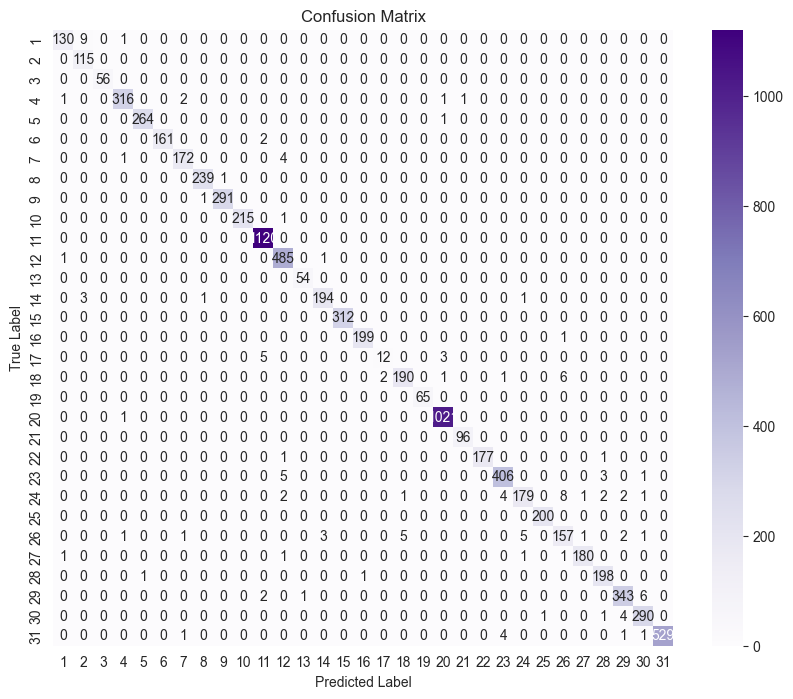

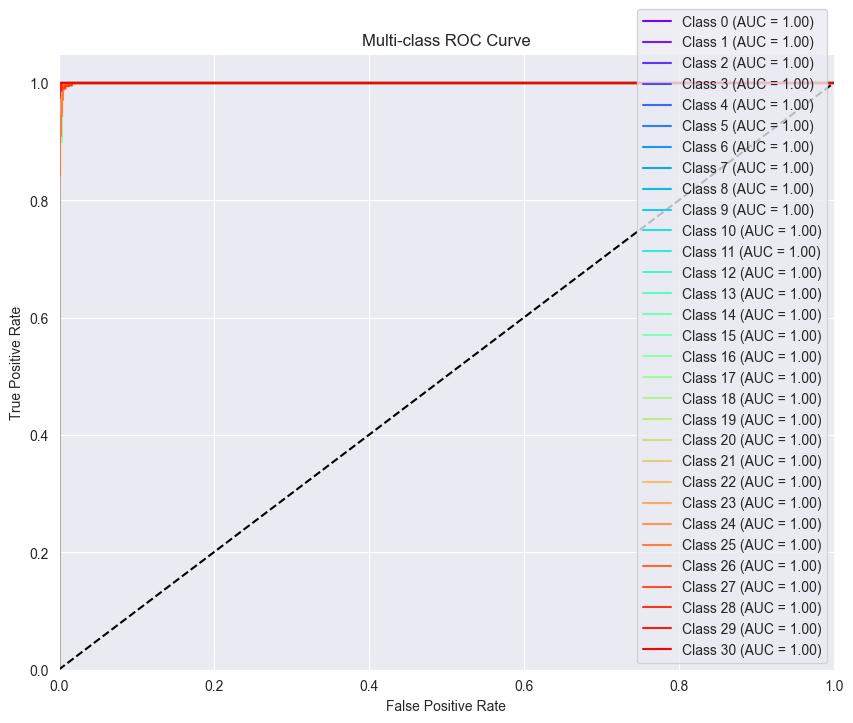

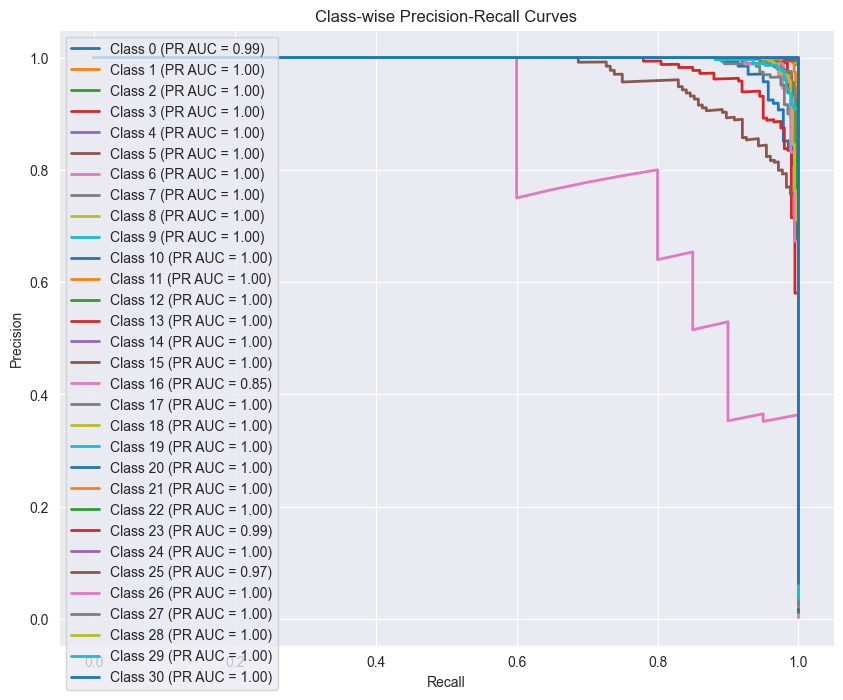

Epoch [10/20]: 100%|██████████| 1063/1063 [02:36<00:00,  6.80it/s, loss=6.41e-5]


Accuracy: 98.75%
F1 Score: 0.99


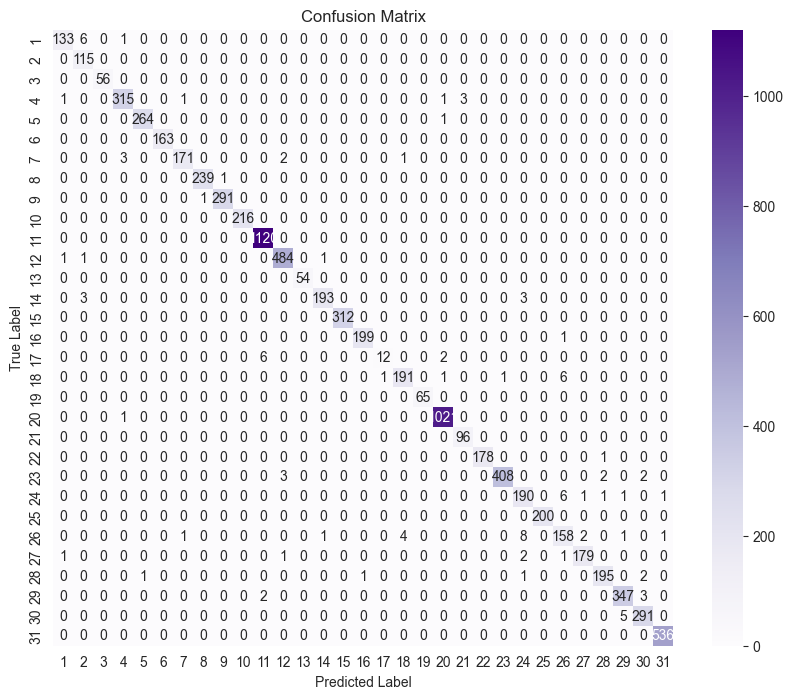

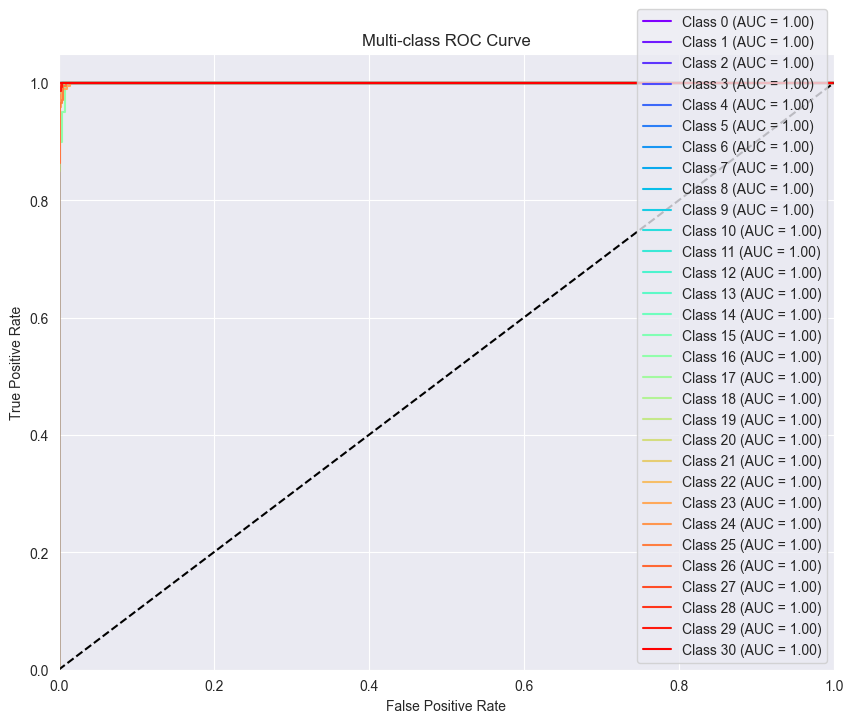

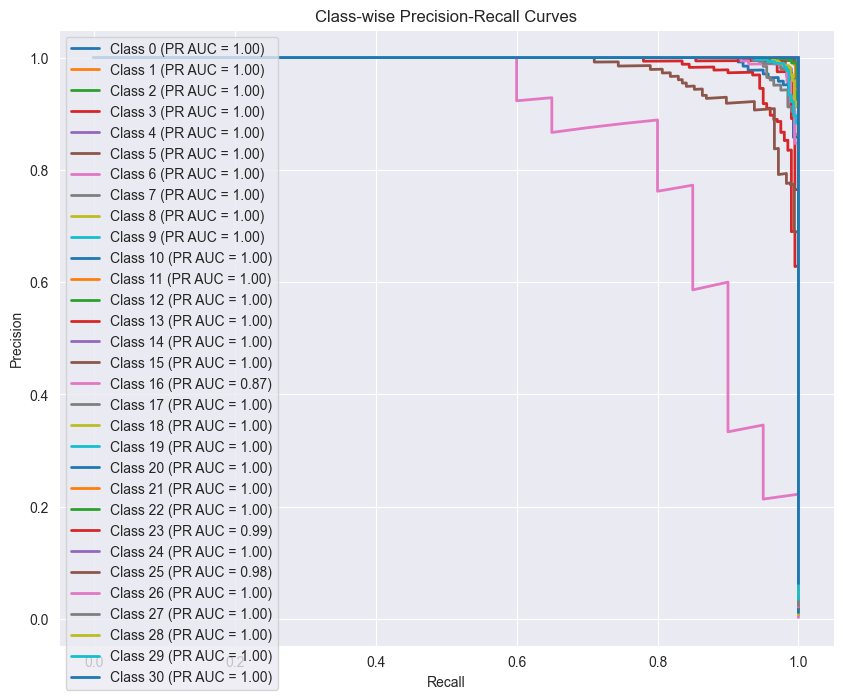

Epoch [15/20]: 100%|██████████| 1063/1063 [02:36<00:00,  6.80it/s, loss=2.92e-5]


Accuracy: 98.82%
F1 Score: 0.99


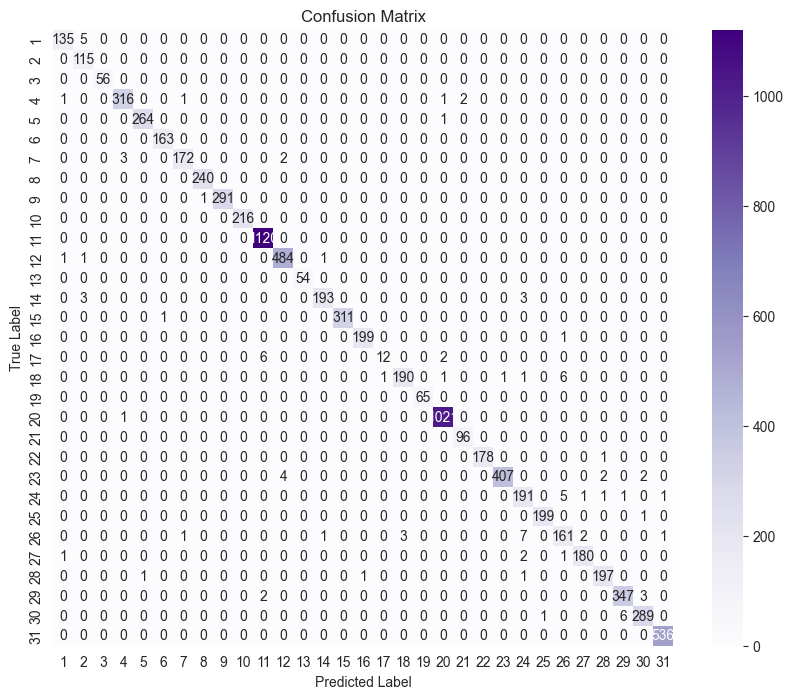

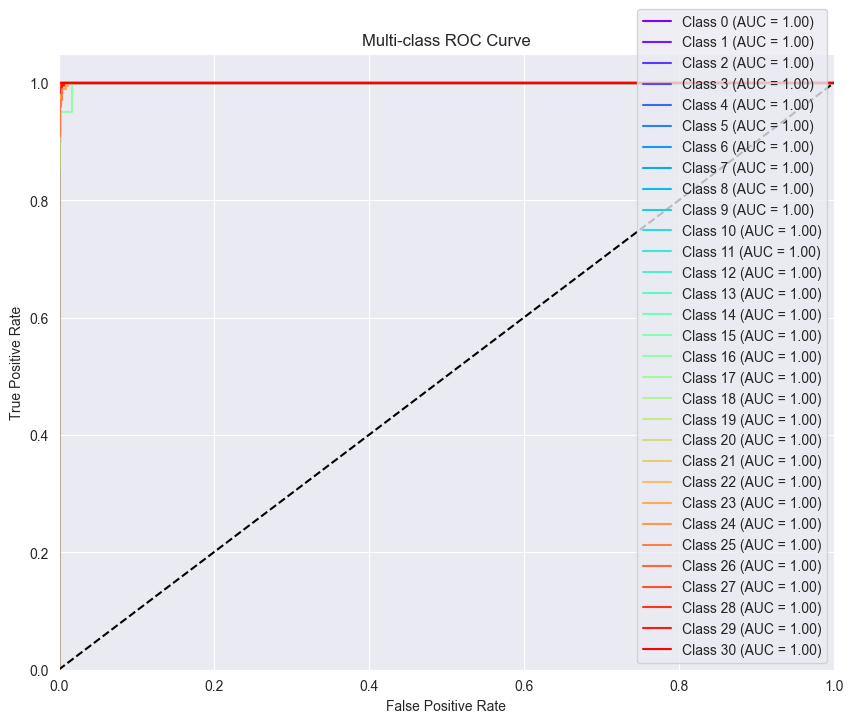

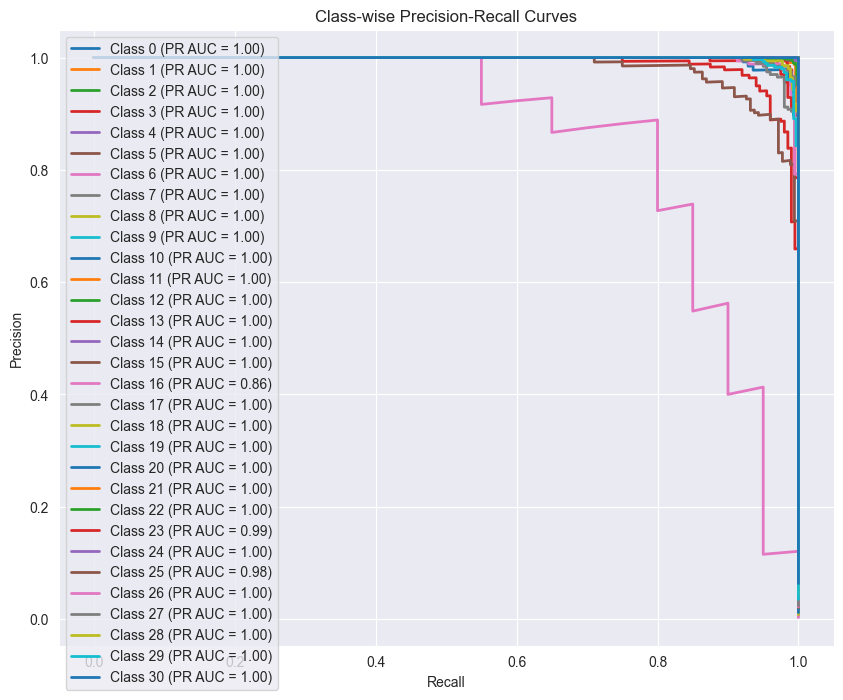

Epoch [20/20]: 100%|██████████| 1063/1063 [02:35<00:00,  6.82it/s, loss=5.51e-6]


Accuracy: 98.88%
F1 Score: 0.99


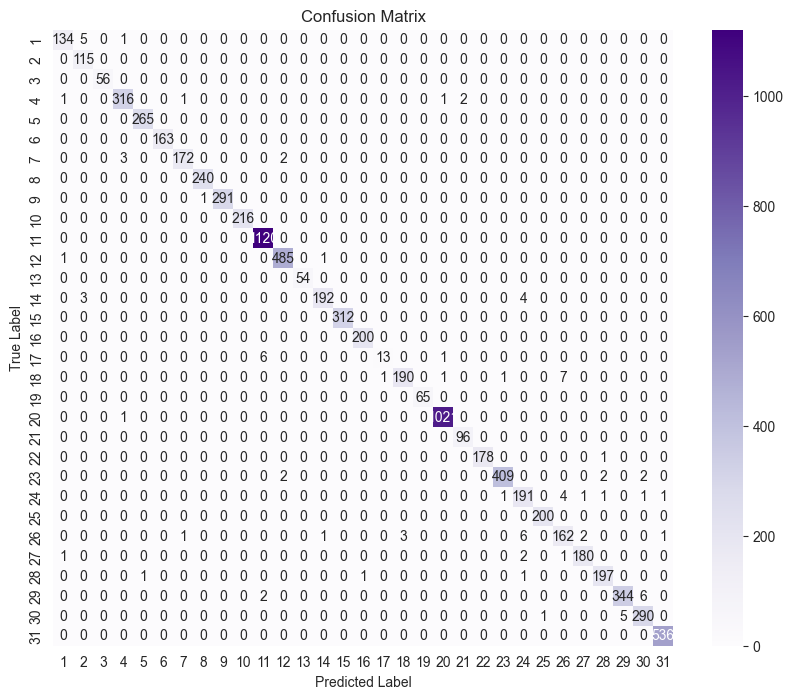

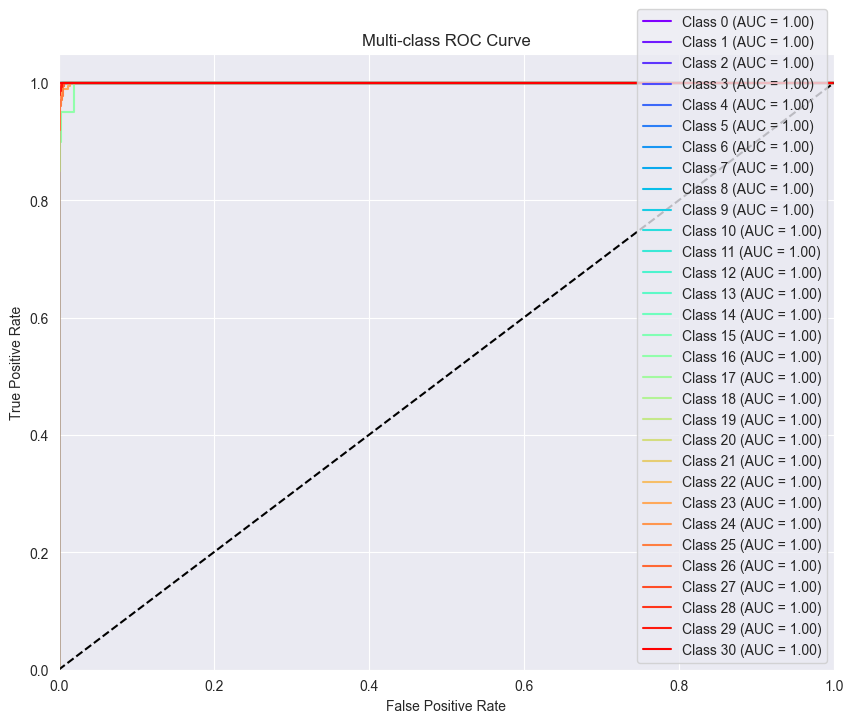

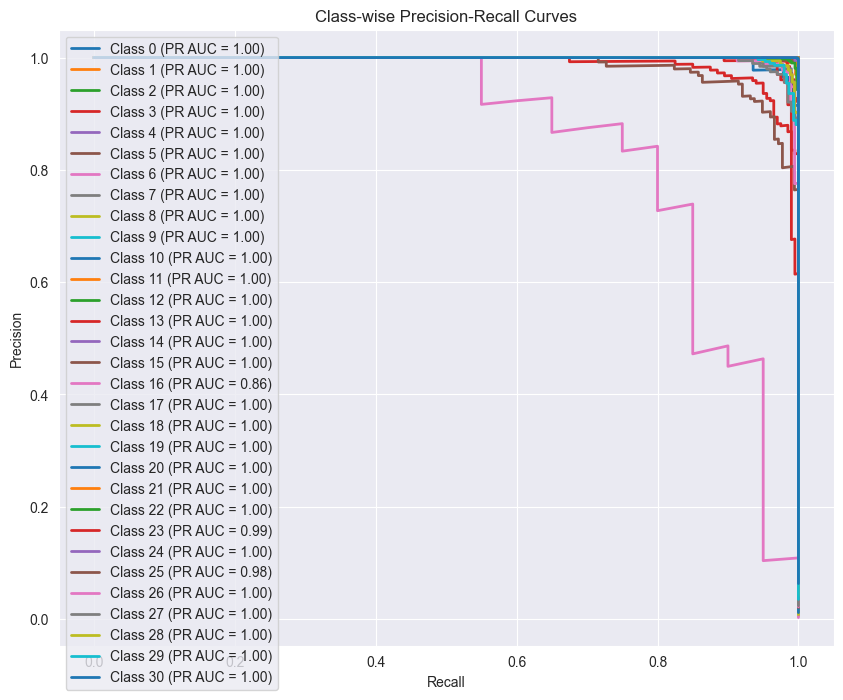

Starting training with batch size=1, learning rate=0.001, epoch=20


Epoch [5/20]: 100%|██████████| 34011/34011 [07:08<00:00, 79.40it/s, loss=4.55]


Accuracy: 58.32%
F1 Score: 0.58


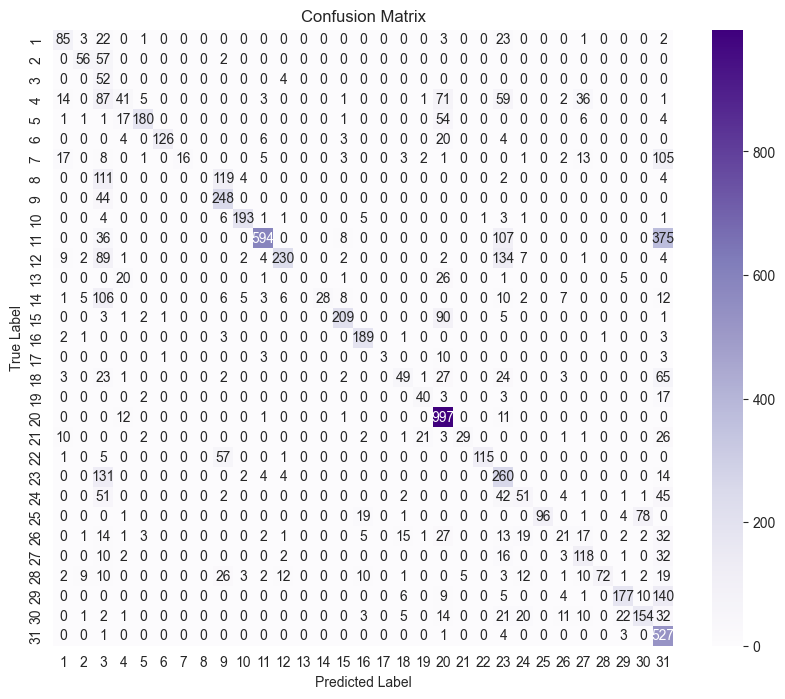

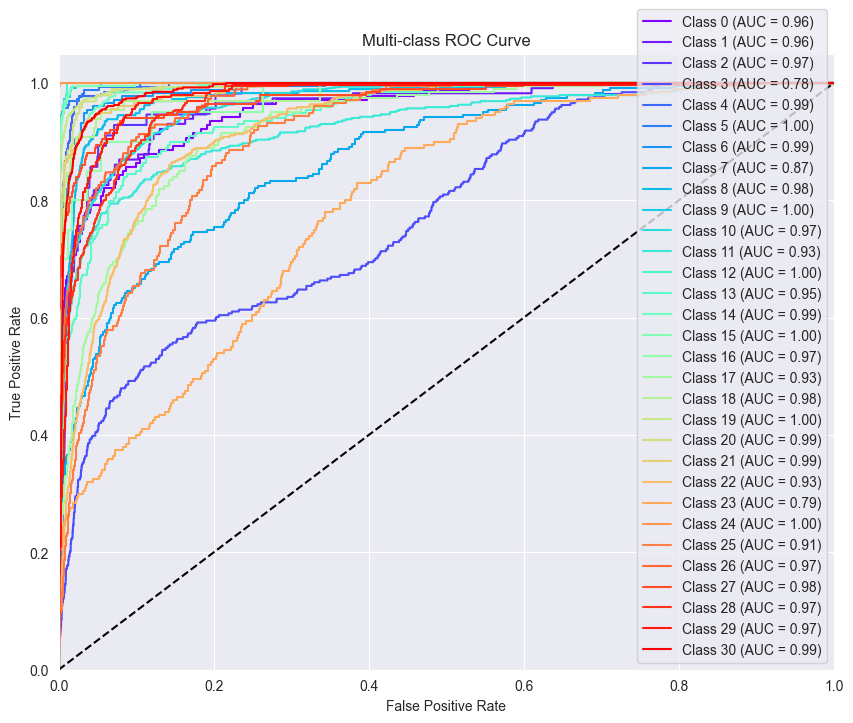

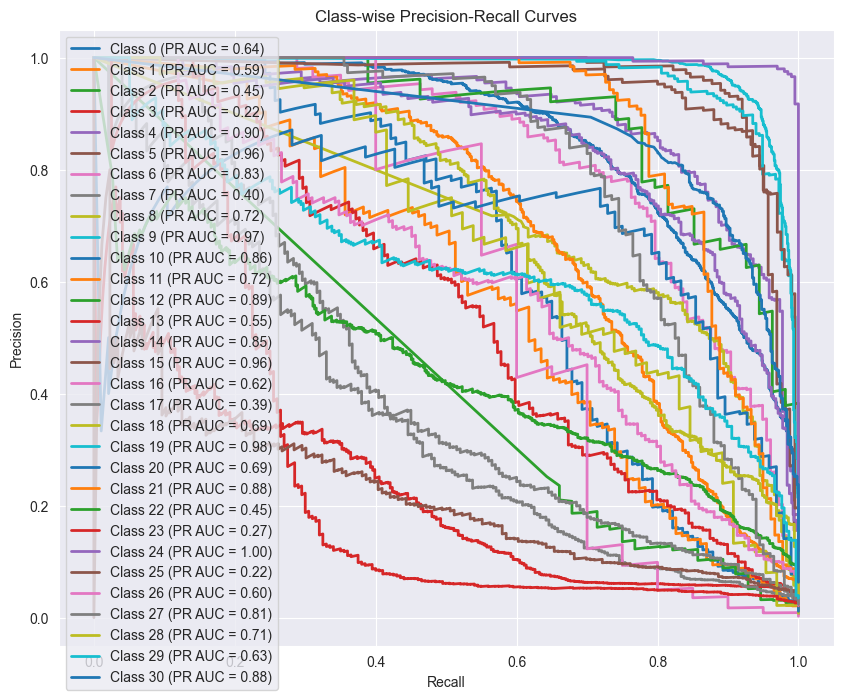

Epoch [9/20]:  36%|███▌      | 12109/34011 [3:18:55<06:05, 59.95it/s, loss=2.52]      

In [ ]:
from tqdm import tqdm

model = GoogLeNet().to(device)
criterion = nn.CrossEntropyLoss()
for batch_size in batch_sizes:
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    for learning_rate in learning_rates:
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        for epoch in epochs:
            model.train()
            print(f'Starting training with batch size={batch_size}, learning rate={learning_rate}, epoch={epoch}')
            for curr_epoch in range(epoch):
                loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
                total_loss = 0
                for i, (inputs, labels) in loop:
                    inputs, labels = inputs.to(device), labels.to(device)

                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    total_loss += loss.item()
                    loop.set_description(f'Epoch [{curr_epoch + 1}/{epoch}]')
                    loop.set_postfix(loss=total_loss/(i + 1))
                    
                if (curr_epoch + 1) % 5 == 0:
                    true_labels, predicted_labels, probabilities = evaluate_model(model, device, test_loader, classes)
                    plot_confusion_matrix(true_labels, predicted_labels, classes)
                    plot_roc_curve_multiclass(31, true_labels, probabilities)
                    plot_precision_recall(true_labels, probabilities, 31)